Calculate inprop for central brain neurons on a signle neuron level. Optic lobe neurons are not included. Input from the optic lobe from the central brain is through the visual_projection neurons, which are preserved.  
The following synapses are removed: 
- postsynapses in fan-shaped body for **tangential neurons**; 
- postsynapses in elipsoid body for **PEN** neurons (since they are supposed to get input from protocerebral bridge); 
    - together with the ring neuron -> PEN connections (only in EB)
    - and ExR neuron -> PEN connections (only in EB)
- postsynapses in noduli for **PEN** neurons; 
- postsynapses in elipsoid body for **ring neurons** (since they are supposed to get input from outside the EB); 
    - together with EPG -> ring neuron connections (only in EB)
- postsynapses in the protocerebral bridge for **IbSpsP** neurons, and all Delta7 (intrinsic to the PB) -> IbSpsP connections. 
- postsynapses in the protocerebral bridge for **EPG** neurons (since they are supposed to get input from EB);
- ~~presynapses in the EB for **EPG**~~ - these are kept for now, for excitation from adjacent edges; 
- connections between **hDelta** neurosn and **EPG**: hDelta go to the FB, EPG does not. 
- postsynapses for **ExR4**, **ExR5** and **ExR6** in the axon-like compartments; 
- postsynapses for **LPsP** in EB; 
- postsynapses in all but PB for **PEG** since PEG has dendrites in the PB; 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

# reading data

In [2]:
info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',
                   delimiter = '\t')
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_26144\649695127.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [3]:
info.super_class.value_counts(dropna = False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [4]:
info.ito_lee_hemilineage.unique()

array(['SMPpv2_ventral', 'VLPl2_medial', nan, 'putative_primary',
       'VLPl&d1_lateral', 'VPNp2', 'VLPl1_or_VLPl5', 'VLPa1_lateral',
       'VPNl&d1_lateral', 'VLPl&p1_lateral', 'VLPd1', 'SMPad1',
       'VLPl&d1_dorsal', 'SMPad2', 'DILP__prim', 'DM1_CX_p', 'SMPad3',
       'SLPal5', 'SLPal2', 'LHa3', 'SLPa&l1_lateral', 'SLPav2', 'LHa1',
       'SIPa1_ventral', 'CREa2_medial', 'VLPp&l1_anterior', 'LHp3',
       'SLPp&v1_posterior', 'MBp4', 'DM1_CX_d2', 'DM1_antero_dorsal',
       'SLPpl1', 'DM3_CX_v', 'DM2_CX_p', 'SMPpm1', 'DM2_CX_d1',
       'DM2_CX_d2', 'primary', 'DM2_central', 'MBp1', 'DM3_CX_p',
       'DM1_CX_v', 'SLPad1_posterior', 'LHp2', 'VLPl2_posterior',
       'VPNp1_lateral', 'VPNd2', 'SLPav1_medial', 'LHa2', 'VPNd3',
       'VPNp1_medial', 'VPNp&v1_posterior', 'VPNd1', 'VPNp3',
       'VLPl4_anterior', 'MX3', 'VLPl&p2_lateral', 'MX12__prim',
       'MX0__prim', 'MD0__prim', 'LB19', 'LB3', 'LB0_anterior', 'FLAa3',
       'LB5', 'WEDa1', 'VLPd&p1_posterior', 'ALad1__prim

In [5]:
# to make the matrix smaller, let's take visual projection neurons as visual input, and remove the optic lobe neurons
cb = info[~info.super_class.isin(['optic'])]
# filter out the visual sensory neurons, except for the ocellar ones
cb = cb[(cb.cell_class != 'visual') | (cb.cell_type == 'ocellar retinula cell')]
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,morphology_group,top_nt,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,NaN,acetylcholine,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,VLPl2_medial__0,acetylcholine,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,NaN,acetylcholine,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,NaN,acetylcholine,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,NaN,acetylcholine,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123502,79587599823629322,720575940618417409,130350,14001,3229,NaN,NaN,NaN,NaN,afferent,...,NaN,NaN,NaN,NaN,NaN,left,OCN,fw123599,FBbt_00004242,NaN
123503,79587599823608864,720575940628941553,130046,14747,3205,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.734219,NaN,NaN,left,OCN,fw123600,FBbt_00004242,NaN
123504,79728680842360672,720575940612567258,132026,19096,3069,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.729409,NaN,NaN,center,OCN,fw123601,FBbt_00004242,NaN
123505,79798912214529467,720575940630757750,133378,17839,3166,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.544816,NaN,NaN,center,OCN,fw123602,FBbt_00004242,NaN


In [6]:
cb["combined_type"] = cb.cell_type
# fill the leftover nas with hemibrain_type
cb.combined_type.fillna(cb.hemibrain_type, inplace= True)
cb.combined_type.value_counts()

combined_type
KCg-m           2190
KCab            1643
BM_InOm         1111
LC12             380
TmY14            370
                ... 
PS230,PLP242       1
CB1453             1
AVLP458            1
PLP243             1
DNge151            1
Name: count, Length: 8290, dtype: int64

In [7]:
# fill the still leftover nas with root ids
cb.combined_type.fillna(cb.root_id.astype(str), inplace= True)

In [8]:
# make dictionaries to map between columns 
typedict = dict(zip(cb.root_id, cb.combined_type))
sidedict = dict(zip(cb.root_id, cb.side))
type_super_class_dict = dict(zip(cb.combined_type, cb.super_class))
type_class_dict = dict(zip(cb.combined_type, cb.cell_class)) 
type_sub_class_dict = dict(zip(cb.combined_type, cb.cell_sub_class))

## read connectivity

In [9]:
import platform 

if platform.system() == 'Windows': 
    # using updated connectivity from Sven 
    conn = pd.read_feather(
        'C:/Users/44745/Downloads/syn_proof_analysis_filtered_consolidated_ntavg_783.feather')
else: 
    conn = pd.read_feather('/Users/yijieyin/Downloads/syn_proof_analysis_filtered_consolidated_783.feather')

conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


# NT

In [10]:
cb.top_nt.value_counts(dropna = False)

top_nt
acetylcholine    28338
glutamate         8759
dopamine          5850
gaba              5643
serotonin         1773
NaN                146
octopamine          92
Name: count, dtype: int64

In [11]:
cb.known_nt.unique()

array([nan, 'acetylcholine', 'DILP2, DILP3, DILP5', 'glutamate',
       'glutamate, sparkly, proctolin, Nplp1',
       'dopamine, sparkly, Nplp1, amnesiac, CG43117, ion-transport peptide, nitric oxide',
       'gaba', 'acetylcholine, Nplp1, sNPF, sparkly',
       'glutamate, Dh44, allatostatin-c', 'dopamine',
       'acetylcholine, sNPF, sparkly', 'Dh44', 'octopamine',
       'acetylcholine, sparkly',
       'dopamine, amnesiac, sparkly, Nplp1, CG34136, sNPF', 'CCHa2R',
       'Drosulfakinin', 'gaba, myoinhibitory peptide',
       'dopamine, Nplp1, sNPF, sparkly, amnesiac, CG34136',
       'dopamine, amnesiac, sparkly, Dh44, CG34136, Nplp1',
       'allatostatin-a, glutamate', 'CCHa1, Dh44, glutamate',
       'dopamine, amnesiac, sparkly, pdf, Gpb5', 'Dh31',
       'acetylcholine, space blanket',
       'gaba, serotonin, sparkly, Nplp1, proctolin, orcokinin, eclosion hormone, CG34136',
       'serotonin', 'dopamine, nitric oxide', 'glutamate, leucokinin',
       'corazonin, sNPF', 'all

In [12]:
# known_nt takes priority 
cb['known_nt_simplified'] = cb.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
cb.known_nt_simplified = cb.known_nt_simplified.str.extract('(glutamate|gaba|acetylcholine)', expand = False)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
cb.known_nt_simplified.value_counts(dropna = False)

# then use this column to replace values in top_nt column 
cb.top_nt = cb.known_nt_simplified.fillna(cb.top_nt)

(array([9.055e+03, 5.110e+02, 0.000e+00, 5.200e+01, 0.000e+00, 1.900e+01,
        3.000e+00, 0.000e+00, 5.000e+00, 1.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

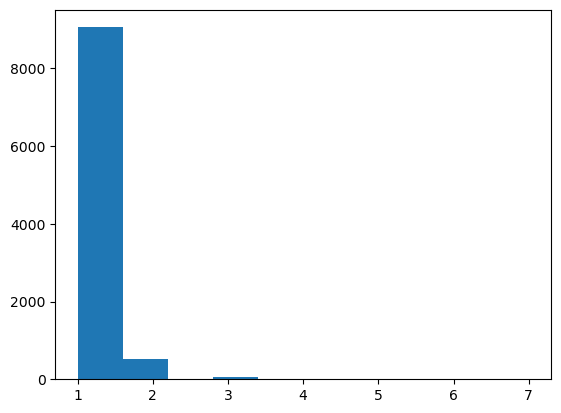

In [13]:
# first check consistency of NT within each type 
cb['top_nt'] = cb['top_nt'].fillna('unknown')
nt_count_per_type = cb.groupby('combined_type')['top_nt'].nunique()
plt.hist(nt_count_per_type)

In [14]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = cb[cb.combined_type.isin(nt_conflict_types)].groupby(['combined_type', 'top_nt']).size()

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name='counts')

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(by=['combined_type', 'counts'], ascending=[True, False], inplace=True)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(cb.combined_type, cb.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []

# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df['counts'].max()
    top_nts = df[df['counts'] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(df['combined_type'].iloc[0])  # Record the type with ties
        random_nt = np.random.choice(top_nts['top_nt'].values)
        while random_nt == 'unknown': 
            random_nt = np.random.choice(top_nts['top_nt'].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts['top_nt'].values[0]

# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts['combined_type'] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

232

In [15]:
# the types without any known nt 
[atype for atype, nt in type_nt.items() if nt == 'unknown']

['720575940638707901',
 'DNge061',
 '720575940612376690',
 'ITP',
 '720575940626896145',
 '720575940622611917',
 '720575940624156391',
 '720575940632738259',
 '720575940621636988',
 '720575940610239608',
 '720575940623382711',
 '720575940612269283',
 'AN_GNG_204',
 'AN_GNG_124',
 '720575940614957115',
 '720575940626216720',
 '720575940621463699',
 '720575940606375772',
 '720575940610183154',
 '720575940617816661',
 '720575940635901274',
 '720575940612137895',
 '720575940621568490',
 '720575940619617919',
 '720575940628335611',
 '720575940633705560',
 '720575940637470627',
 '720575940639152117',
 '720575940638909429',
 '720575940614736699',
 '720575940611937967',
 '720575940613684274',
 '720575940625771780',
 '720575940619904380',
 '720575940630846125',
 '720575940624211202',
 '720575940611477229',
 '720575940628628055',
 '720575940618759078',
 '720575940629273130',
 '720575940618109460',
 '720575940611810001',
 '720575940628268226',
 '720575940620287820',
 '720575940623758669',
 '72057

In [16]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary 
nt_value = {'acetylcholine': 1, 
           'glutamate': -1, 
           'gaba': -1, 
           'dopamine': 1, 
           'serotonin': 1, 
           'octopamine': 1, 
           'unknown': 1}

# modify connectivity

In [17]:
conn = conn[(conn.pre_pt_root_id.isin(cb.root_id)) &
            (conn.post_pt_root_id.isin(cb.root_id))]

## tangential neurons

In [18]:
# modify connectivity as needed
conn.loc[:, ['pre_type']] = conn.pre_pt_root_id.map(typedict)
conn.loc[:, ['post_type']] = conn.post_pt_root_id.map(typedict)

# inspect total pre-synapses for the tangential neurons in each neuropil
conn[conn.post_type.str.contains('CB.FB')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False).to_clipboard()
# result written to clipboard

In [19]:
# remove input in tangential neurons in the CX
conn = conn[(~conn.post_type.str.contains('CB.FB')) | (
    conn.post_type.str.contains('CB.FB') & ~conn.neuropil.isin(['FB', 'NO', 'EB']))]
conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,0.272418,4.812546e-02,0.000472,0.000951,PLP017,CB3488
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,0.580512,8.166312e-04,0.000857,0.007278,LHPV6p1,AVLP314
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,0.001811,1.633383e-05,0.005870,0.011328,CB0960,CB0710
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,0.472987,9.134340e-03,0.086973,0.387136,CB0960,CB2317
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,0.000522,3.998458e-07,0.000103,0.000040,LAL138,CB2018
...,...,...,...,...,...,...,...,...,...,...,...,...
16847984,720575940627253510,720575940621326430,SMP_L,1,0.007995,0.983840,0.000792,9.907485e-04,0.000257,0.006124,CB1744,SLP134
16847990,720575940622010373,720575940634459290,VES_R,2,0.446577,0.407034,0.084707,1.664534e-03,0.007724,0.052293,DNg55,DNb08_a
16847991,720575940624054792,720575940634431935,ICL_L,5,0.012248,0.916746,0.017556,2.496850e-02,0.001025,0.027456,PVLP012,PVLP070
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,0.032063,1.844075e-03,0.028945,0.036396,PVLP007,AVLP089


## PEN

In [20]:
# from which cell types and neuropils are the input for PEN neurons? 
conn[conn.post_type.str.contains('PEN')].groupby(['pre_type', 'neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False).to_clipboard()

In [21]:
conn[conn.post_type.str.contains('PEN')].groupby(['neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
2,EB,17827
6,NO,14282
7,PB,6204
3,FB,54
1,ATL_R,17
4,IB_L,4
5,LAL_L,3
8,SPS_L,3
0,ATL_L,1
9,UNASGD,1


In [22]:
# remove input in the PEN neurons in EB and NO 
# NOTE PEN from different wedges connect with each other in NO; they receive LR different input from GLNO in NO
conn = conn[(~conn.post_type.str.contains('PEN')) | (
    conn.post_type.str.contains('PEN') & ~conn.neuropil.isin(['EB','NO']))]

In [23]:
# and remove specifically input from ring neurons to the PEN neuorns 
conn = conn[~(conn.pre_type.str.contains('ER') & conn.post_type.str.contains('PEN'))]
# and remove specifically input from ExR neurons to PEN neurons 
conn = conn[~(conn.pre_type.str.contains('ExR') & conn.post_type.str.contains('PEN'))]

## ring neurons

In [24]:
# presynapse locations for ring neurons 
conn[conn.post_type.str.contains('ER')].groupby(['neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
7,EB,128965
8,FB,5789
4,BU_R,4814
5,CRE_L,3346
6,CRE_R,2999
9,GA_L,2582
10,GA_R,2256
14,LAL_R,1791
13,LAL_L,1748
3,BU_L,1357


In [25]:
# remove input in the ring neurons in EB and FB
conn = conn[(~conn.post_type.str.contains('ER')) | (
    conn.post_type.str.contains('ER') & ~conn.neuropil.isin(['EB', 'FB']))]
# and remove input from EPG to ring neurons 
conn = conn[~(conn.pre_type.str.contains('EPG') & conn.post_type.str.contains('ER'))]

In [26]:
# check neuropil of connections from EL to ring neurons
conn[conn.pre_type.str.contains('EL') & conn.post_type.str.contains('ER')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
4,MB_ML_L,19
5,MB_ML_R,17
2,LAL_L,5
1,GA_L,4
0,CRE_L,3
3,LAL_R,1


In [27]:
# remove connections from EL to ring neurons 
conn = conn[~(conn.pre_type.str.contains('EL') & conn.post_type.str.contains('ER'))]

## PEG

In [28]:
# PEG should only receive input from PB. Which neuropils is it receiving input from? 
conn[conn.post_type.str.contains('PEG')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
15,PB,5074
4,EB,3085
6,GA_L,815
7,GA_R,756
14,NO,160
5,FB,141
3,CRE_R,84
13,MB_ML_R,69
1,ATL_R,15
0,ATL_L,7


In [29]:
# remove postsynapses for PEG except for PB 
conn = conn[(~conn.post_type.str.contains('PEG')) | (
    conn.post_type.str.contains('PEG') & conn.neuropil.isin(['PB']))]

## ExR5

In [30]:
# ExR5 upstream neuropils 
conn[conn.post_type.str.contains('ExR5')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
4,EB,3217
5,FB,1313
27,SPS_R,222
26,SPS_L,175
3,CRE_R,161
2,CRE_L,113
6,GA_L,108
9,IB_L,73
7,GA_R,68
10,IB_R,53


In [31]:
# ExR5 has input posteriorly 
# NOTE that this removes most of the input to ExR5 neurons
conn = conn[(~conn.post_type.str.contains('ExR5')) | (
    conn.post_type.str.contains('ExR5') & ~conn.neuropil.isin(['EB','FB','CRE_L','CRE_R','GA_L','GA_R','NO','LAL_L','LAL_R']))]

In [32]:
# check specifically between EPG and ExR5
conn[(conn.pre_type.str.contains('EPG')) & (conn.post_type.str.contains('ExR5'))]

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type
5547780,720575940620282906,720575940621268830,MB_ML_R,1,0.252942,0.586589,0.049792,0.00206,0.008015,0.100603,EPG,ExR5


## ExR6

In [33]:
# input neuropils for ExR6 
conn[conn.post_type.str.contains('ExR6')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
5,EB,4432
7,GA_L,1455
4,CRE_R,1215
8,GA_R,1137
10,LAL_R,1130
9,LAL_L,1027
3,CRE_L,755
12,MB_ML_R,342
11,MB_ML_L,158
14,NO,110


In [34]:
# remove input from EB 
conn = conn[(~conn.post_type.str.contains('ExR6')) | (
    conn.post_type.str.contains('ExR6') & ~conn.neuropil.isin(['EB']))]

## ExR4

In [35]:
# input compartments for ExR4 
conn[conn.post_type.str.contains('ExR4')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
2,EB,2650
4,GA_L,1323
7,LAL_L,493
5,GA_R,484
0,CRE_L,255
8,LAL_R,248
1,CRE_R,210
10,MB_ML_R,173
11,NO,173
9,MB_ML_L,24


In [36]:
# remove input from EB 
conn = conn[(~conn.post_type.str.contains('ExR4')) | (
    conn.post_type.str.contains('ExR4') & ~conn.neuropil.isin(['EB']))]

## EPG

In [37]:
# remove synapses between hDelta and EPG neurons 
conn = conn[~(conn.pre_type.str.contains('hDelta') & conn.post_type.str.contains('EPG'))]
conn = conn[~(conn.pre_type.str.contains('EPG') & conn.post_type.str.contains('hDelta'))]

In [38]:
# check the location of the post-syanpses in EPG 
conn[conn.post_type.str.contains('EPG')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
5,EB,56814
18,PB,3805
7,GA_L,1890
8,GA_R,1577
17,NO,601
4,CRE_R,559
6,FB,358
15,MB_ML_R,215
3,CRE_L,130
12,LAL_L,40


In [39]:
# and check specifically the neuropils between EPG neurons 
conn[conn.post_type.str.contains('EPG') & conn.pre_type.str.contains('EPG')].groupby('neuropil').syn_count.sum(
    ).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
2,EB,2589
4,GA_L,154
1,CRE_R,151
13,PB,83
5,GA_R,69
12,NO,32
10,MB_ML_R,10
0,CRE_L,8
8,LAL_L,3
3,FB,2


In [40]:
# since EPGs should receive input from EB, remove postsynapses in other neuropils
conn = conn[(~conn.post_type.str.contains('EPG')) | (
    conn.post_type.str.contains('EPG') & ~conn.neuropil.isin(['PB', 'GA_L', 'GA_R', 'CRE_R', 'CRE_L']))]

In [41]:
# there are quite a few EPG postsynapses in MB_ML_R. Which cell types? 
conn[conn.post_type.str.contains('EPG') & conn.neuropil.isin(['MB_ML_R'])].groupby('pre_type').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,pre_type,syn_count
10,LAL184,73
7,ExR6,61
2,ER6,36
3,ExR1,16
0,EPG,10
11,PEG,6
4,ExR2_1,3
13,PS196b,3
1,ER4d,2
5,ExR2_2,1


In [42]:
# it shouldn't be receiving input from LAL184 at least 
conn = conn[~(conn.pre_type.str.contains('LAL184') & conn.post_type.str.contains('EPG'))]

In [43]:
# and EPGs should not send output in EB 
# first check locations of presynapses 
conn[conn.pre_type.str.contains('EPG')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
15,PB,12069
4,EB,10190
6,GA_L,2508
7,GA_R,1706
3,CRE_R,487
12,MB_ML_R,328
14,NO,265
5,FB,110
2,CRE_L,67
11,MB_ML_L,22


In [44]:
# which cell types are downstream of EPG neurons in EB?
conn[conn.pre_type.str.contains('EPG') & conn.neuropil.isin(['EB'])].groupby('post_type').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,post_type,syn_count
7,EL,6482
8,EPG,2572
14,ExR7,484
15,ExR8,260
11,ExR2_1,107
12,ExR2_2,78
10,ExR1,52
17,PFNv,35
16,PFGs,30
3,720575940619574181,19


In [45]:
# there is some structure in the EPG-EPG connections in EB (nearby excitation), and ExR7&8 have hairy axons in the EB, so let's keep the EPG presynapses in EB for now.  
# # EPG should not have output in EB 
# conn = conn[(~conn.pre_type.str.contains('EPG')) | (
#     conn.pre_type.str.contains('EPG') & ~conn.neuropil.isin(['EB']))]

## IbSpsP

In [46]:
# check synapses presynaptic to IbSpsP neurons 
conn[conn.post_type.str.contains('IbSpsP')].groupby(['pre_type', 'neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False).to_clipboard()

In [47]:
# remove input in the IbSpsP neurons in PB, and with Delta7 neurons, since they only innervate the PB 
conn = conn[(~conn.post_type.str.contains('IbSpsP')) | (
    conn.post_type.str.contains('IbSpsP') & ~conn.neuropil.isin(['PB']))]
conn = conn[~((conn.pre_type.str.contains('Delta7')) & conn.post_type.str.contains('IbSpsP'))]

In [48]:
# and remove the last few synapses from ['P1-9','P6-8P9'] to IbSpsP neurons, since they are in the PB 
conn = conn[~((conn.pre_type.str.contains('P1-9')) & conn.post_type.str.contains('IbSpsP'))]
conn = conn[~((conn.pre_type.str.contains('P6-8P9')) & conn.post_type.str.contains('IbSpsP'))]

## LPsP

In [49]:
# input neuropils for LPsP 
conn[conn.post_type.str.contains('LPsP')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
9,PB,2227
8,LAL_R,456
7,LAL_L,447
5,IPS_L,334
14,WED_R,222
12,SPS_R,107
6,IPS_R,69
13,WED_L,31
11,SPS_L,28
1,ATL_R,15


In [50]:
# remove input in PB for LPsP 
conn = conn[(~conn.post_type.str.contains('LPsP')) | (
    conn.post_type.str.contains('LPsP') & ~conn.neuropil.isin(['PB']))]

# tidy up & save

In [51]:
# sum synapse numbers across neuropils 
conn = conn.groupby(['pre_pt_root_id', 'post_pt_root_id']).syn_count.sum().reset_index()
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940600433181,720575940605214636,10
1,720575940600433181,720575940605353649,3
2,720575940600433181,720575940606938313,1
3,720575940600433181,720575940609527069,1
4,720575940600433181,720575940612058543,3
...,...,...,...
6532309,720575940661338497,720575940635596212,2
6532310,720575940661338497,720575940639769715,1
6532311,720575940661338497,720575940643867296,1
6532312,720575940661338497,720575940645527918,1


In [52]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(cb.root_id)
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node:num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn['pre_idx'] = conn.pre_pt_root_id.map(nodes_to_idx) 
conn['post_idx'] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn['pre_idx'].values
col = conn['post_idx'].values
data = conn['syn_count'].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size/1e6

78.590176

In [53]:
csc.shape

(50601, 50601)

In [54]:
csc

<50601x50601 sparse matrix of type '<class 'numpy.int64'>'
	with 6532314 stored elements in Compressed Sparse Column format>

In [55]:
col_sums = csc.sum(axis=0)
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
# .A turns it from a sparse matrix into a dense np array
col_sums_with_inversion = np.reciprocal(col_sums.A.squeeze().astype(float), where=col_sums.A.squeeze() != 0)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

In [56]:
sp.sparse.save_npz(
    'data/adult_inprop_cb_neuron_no_CX_axonic_postsynapses.npz', inprop)

In [57]:
# save to csv, one row is one neuron 
meta = cb[['root_id', 'combined_type', 'side', 'top_nt', 'super_class',
           'cell_class', 'cell_sub_class', 'ito_lee_hemilineage', 'hartenstein_hemilineage']]
meta.loc[:,['idx']] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ['sign']] = meta.top_nt.map(nt_value)
meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)

# adult, right hemisphere, neuron level, meta information 
meta.to_csv(
    'data/adult_cb_neuron_meta_no_CX_axonic_postsynapses.csv')

C:\Users\44745\AppData\Local\Temp\ipykernel_26144\4112029996.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)


In [58]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,ito_lee_hemilineage,hartenstein_hemilineage,idx,sign
0,720575940628857210,PS180,left,acetylcholine,central,NaN,NaN,SMPpv2_ventral,CP1_ventral,33601,1
1,720575940626838909,CB0924,right,acetylcholine,central,NaN,NaN,VLPl2_medial,BLAv2_medial,29427,1
2,720575940626046919,AVLP429,right,acetylcholine,central,NaN,NaN,NaN,NaN,27805,1
3,720575940630311383,AVLP151,right,acetylcholine,central,NaN,NaN,putative_primary,putative_primary,36434,1
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,NaN,NaN,41325,1
...,...,...,...,...,...,...,...,...,...,...,...
123502,720575940618417409,ocellar retinula cell,left,unknown,sensory,visual,ocellar,NaN,NaN,13370,1
123503,720575940628941553,ocellar retinula cell,left,serotonin,sensory,visual,ocellar,NaN,NaN,33792,1
123504,720575940612567258,ocellar retinula cell,center,serotonin,sensory,visual,ocellar,NaN,NaN,5939,1
123505,720575940630757750,ocellar retinula cell,center,serotonin,sensory,visual,ocellar,NaN,NaN,37288,1
